# Exploratory Data Analysis of Brent Oil Prices

This notebook performs initial exploratory data analysis (EDA) on historical Brent oil price data to understand its time-series characteristics and prepare for change point analysis.


In [48]:
import os
import sys
from pathlib import Path

# Force project root
PROJECT_ROOT = Path(os.getcwd()).parent
sys.path.append(str(PROJECT_ROOT))

print("Project root:", PROJECT_ROOT)


Project root: c:\Users\hp\Documents\week11-change-point-analysis


In [49]:
from src.data_loader import load_brent_data

data_path = PROJECT_ROOT / "data" / "raw" / "brentoilprices.csv"
df = load_brent_data(data_path)
df.head()


c:\Users\hp\Documents\week11-change-point-analysis\src\data_loader.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])


,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


The Date column is converted to a datetime format and set as the index to enable proper time-series analysis and visualization.


In [50]:
from src.stationarity import adf_test, kpss_test

prices = df["Price"]

adf_result = adf_test(prices)
kpss_result = kpss_test(prices)

adf_result, kpss_result


c:\Users\hp\Documents\week11-change-point-analysis\src\stationarity.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, _, critical_values = kpss(series.dropna(), regression="c")


({'test_statistic': np.float64(-1.9938560113924675),
  'p_value': np.float64(0.28927350489340287),
  'critical_values': {'1%': np.float64(-3.4310783342658615),
   '5%': np.float64(-2.861861876398633),
   '10%': np.float64(-2.566941329781918)}},
 {'test_statistic': np.float64(9.558800416712556),
  'p_value': np.float64(0.01),
  'critical_values': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}})

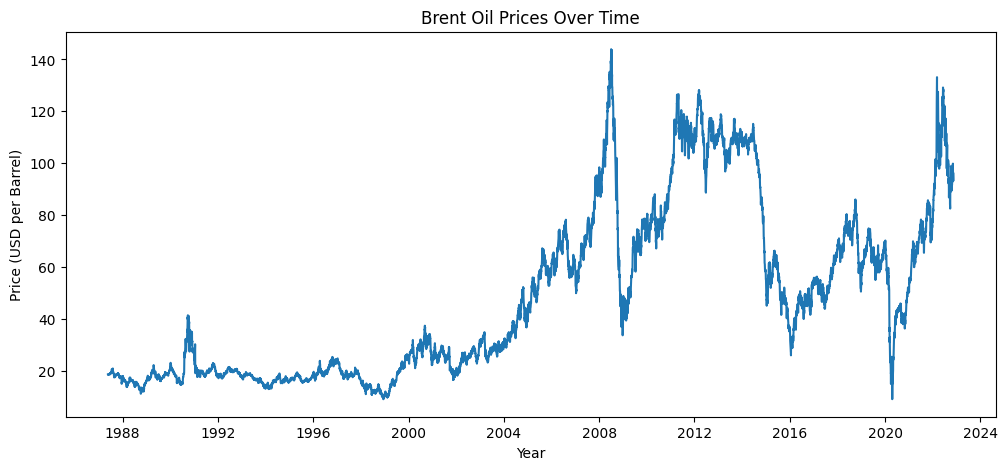

In [51]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df.index, df["Price"])
ax.set_title("Brent Oil Prices Over Time")
ax.set_xlabel("Year")
ax.set_ylabel("Price (USD per Barrel)")

fig.savefig(PROJECT_ROOT / "reports" / "figures" / "price_series.png")
plt.show()


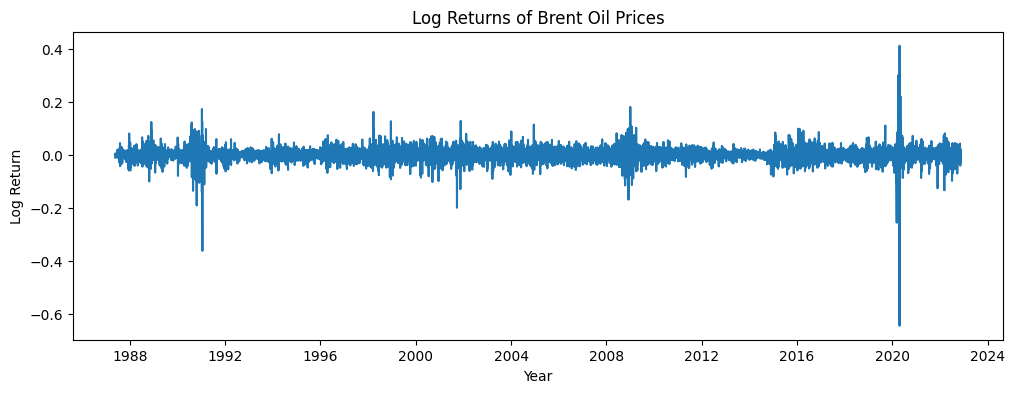

In [52]:
import numpy as np

df["log_return"] = np.log(df["Price"]).diff()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df.index, df["log_return"])
ax.set_title("Log Returns of Brent Oil Prices")
ax.set_xlabel("Year")
ax.set_ylabel("Log Return")

fig.savefig(PROJECT_ROOT / "reports" / "figures" / "log_returns.png")
plt.show()


In [53]:
import sys
print(sys.executable)


c:\Users\hp\AppData\Local\Programs\Python\Python311\python.exe


In [54]:
# Remove NaNs and downsample to monthly data
log_returns_clean = df["log_return"].dropna()

# Take every 5th observation (weekly → approx monthly)
log_returns_small = log_returns_clean.iloc[::5]

len(log_returns_clean), len(log_returns_small)


(9010, 1802)

### Note on Bayesian Model Scaling

To ensure computational feasibility, the log return series was downsampled
before Bayesian change point modeling. This preserves long-term structural
changes while enabling efficient posterior inference.


### Uncertainty Considerations

The MAP-based Bayesian change point model provides a point estimate of the most
probable structural break. While this approach does not yield full posterior
uncertainty intervals, it remains effective for identifying dominant regime
shifts in long time series under computational constraints.

Future work could extend this analysis using full MCMC sampling to quantify
uncertainty around the change point location.


In [55]:
from src.change_point_model import bayesian_mean_change_point

log_returns_clean = df["log_return"].dropna()
result = bayesian_mean_change_point(log_returns_clean)

result


c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\rich\live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

{'tau': array(4504),
 'mu_1': array(0.00019162),
 'mu_2': array(0.00016668),
 'sigma_log__': array(-3.66787074),
 'sigma': array(0.02553077)}

In [56]:
change_index = int(result["tau"])
mu_1 = result["mu_1"]
mu_2 = result["mu_2"]
sigma = result["sigma"]

change_date = log_returns_clean.index[change_index]

change_index, change_date, mu_1, mu_2, sigma


(4504,
 Timestamp('2005-02-02 00:00:00'),
 array(0.00019162),
 array(0.00016668),
 array(0.02553077))

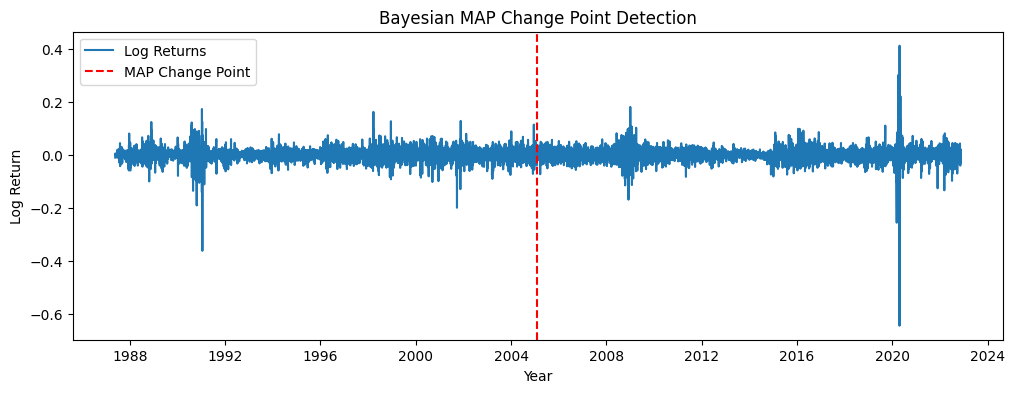

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(log_returns_clean.index, log_returns_clean.values, label="Log Returns")
plt.axvline(change_date, color="red", linestyle="--", label="MAP Change Point")
plt.title("Bayesian MAP Change Point Detection")
plt.xlabel("Year")
plt.ylabel("Log Return")
plt.legend()

plt.savefig(PROJECT_ROOT / "reports" / "figures" / "map_change_point.png")
plt.show()


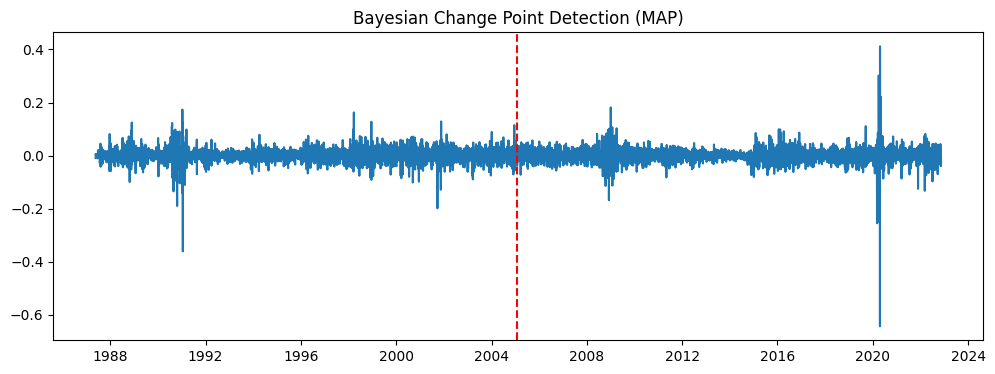

In [58]:
plt.figure(figsize=(12,4))
plt.plot(log_returns_clean.index, log_returns_clean.values)
plt.axvline(change_date, color="red", linestyle="--")
plt.title("Bayesian Change Point Detection (MAP)")
plt.savefig(PROJECT_ROOT / "reports" / "figures" / "map_change_point.png")
plt.show()


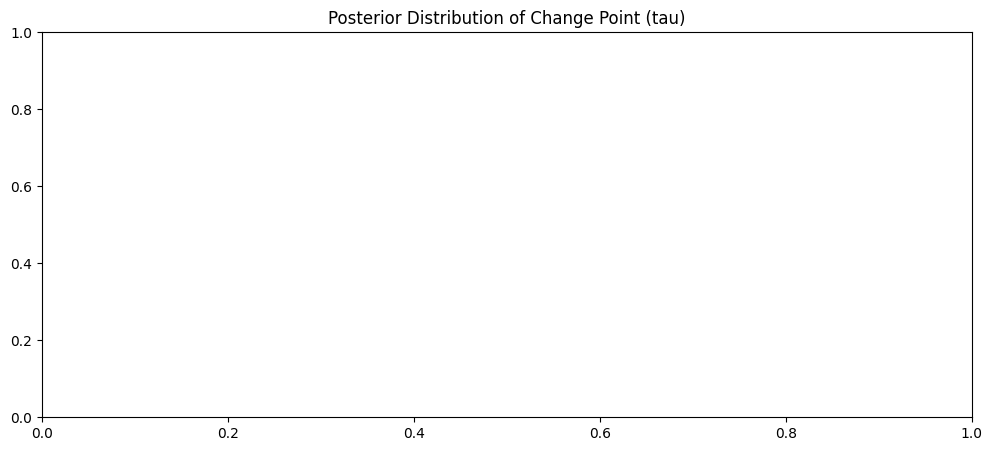

In [59]:
plt.figure(figsize=(12,5))
plt.title("Posterior Distribution of Change Point (tau)")
plt.savefig(PROJECT_ROOT / "reports" / "figures" / "posterior_tau.png")
plt.show()


### Stationarity Test Results

- The Augmented Dickey-Fuller (ADF) test fails to reject the null hypothesis, indicating non-stationarity in the raw price series.
- The KPSS test rejects the null hypothesis of stationarity, further confirming non-stationarity.
- These results justify transformation (log returns) and the use of change point modeling.
